/opt/anaconda3/envs/spatial_env/lib/python3.9/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/anaconda3/envs/spatial_env/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


AnnData object with n_obs × n_vars = 684 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


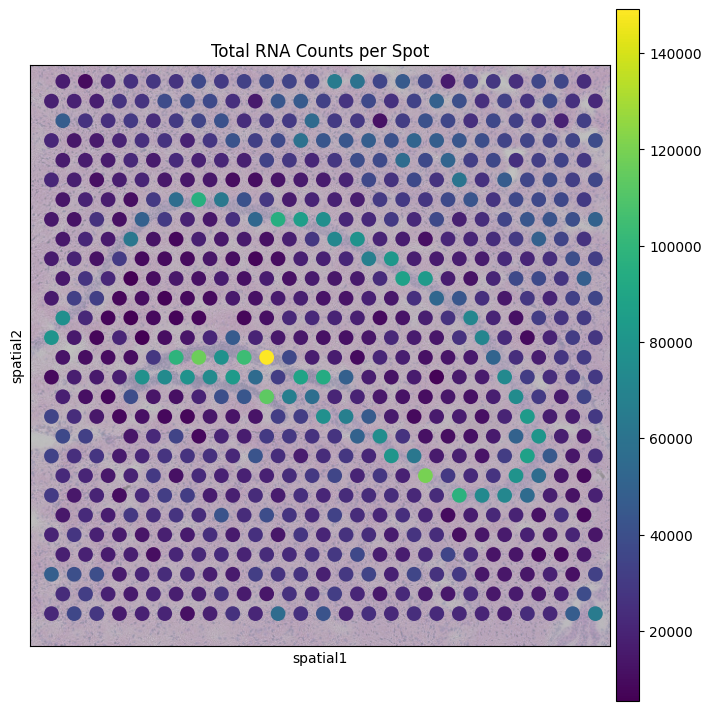

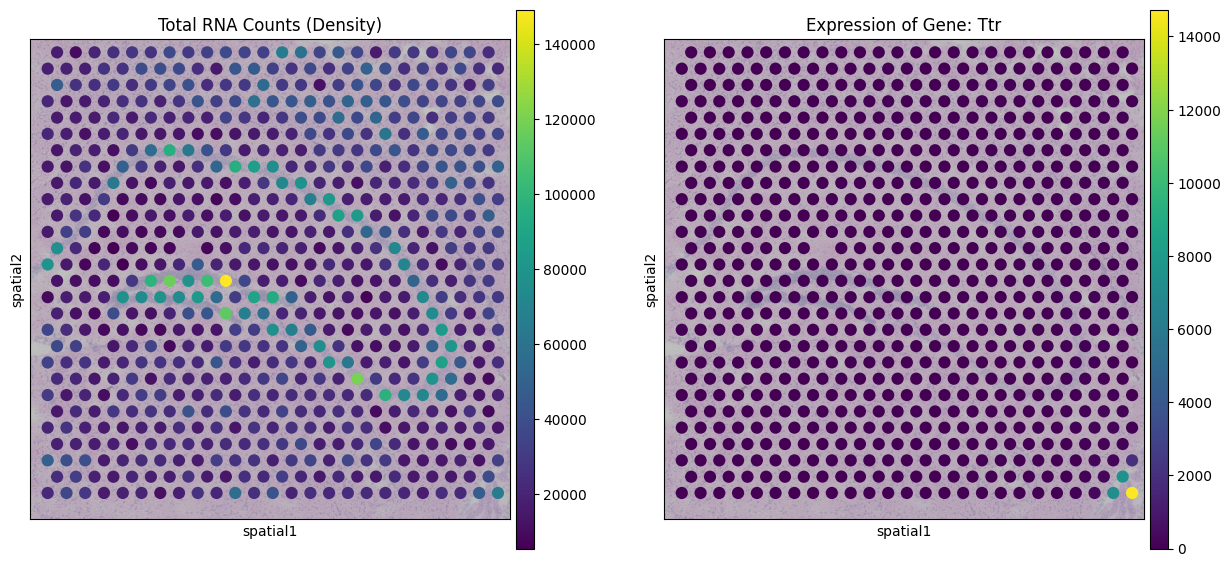

Signature:
sq.datasets.visium_hne_adata_crop(
    path: 'Union[os.PathLike[str], str]' = None,
    **kwargs: 'Any',
) -> 'anndata._core.anndata.AnnData'
Docstring:
Pre-processed subset `10x Genomics Visium H&E dataset <https://support.10xgenomics.com/spatial-gene-expression/datasets/1.1.0/V1_Adult_Mouse_Brain>`__.

The shape of this :class:`anndata.AnnData` object ``(684, 18078)``.

Parameters
----------
path
    Path where to save the dataset.
kwargs
    Keyword arguments for :func:`scanpy.read`.

Returns
-------
The dataset.    
File:      Dynamically generated function. No source code available.
Type:      function

In [1]:
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt

??sq.datasets.visium_hne_adata_crop

# load visium dataset HNE: hematoxylin % eosin
img = sq.datasets.visium_hne_image_crop()
adata = sq.datasets.visium_hne_adata_crop()


print(adata)

sq.pl.spatial_scatter(
    adata,
    color="n_counts",
    img=img,
    img_alpha=0.5,
    title="Total RNA Counts per Spot",
    figsize=(7,7)
)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Total RNA count
sq.pl.spatial_scatter(
    adata, 
    color="n_counts", 
    img=img,
    img_alpha=0.5,
    ax=ax[0],
    title="Total RNA Counts (Density)"
)

# Ttr expression
sq.pl.spatial_scatter(
    adata, 
    color="Ttr", 
    img=img,
    img_alpha=0.5,
    ax=ax[1],
    title="Expression of Gene: Ttr"
)
    

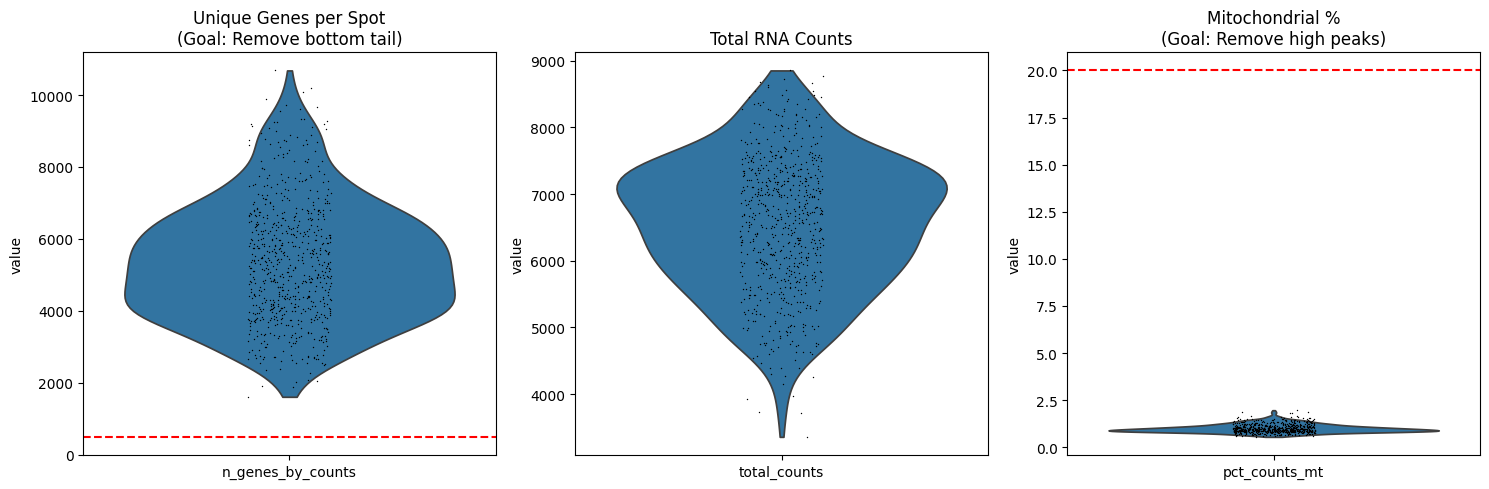

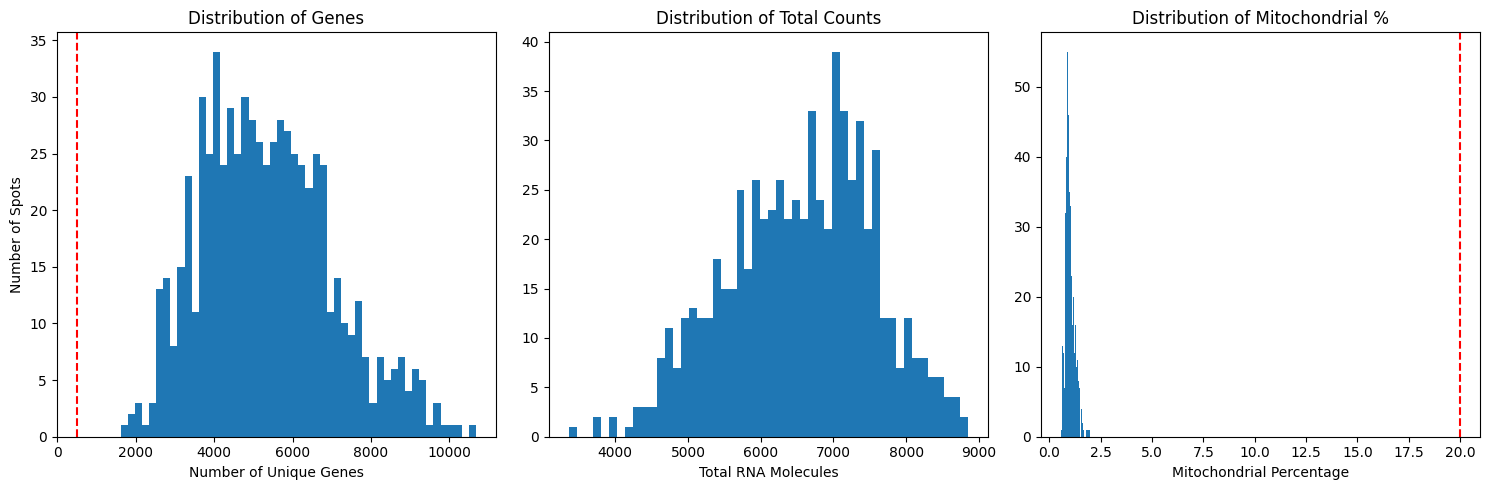

In [2]:
# 1. Flag Mitochondrial Genes
# ---------------------------------------------------------
# We need to know which genes are mitochondrial to calculate stress levels.
# 'adata.var_names' is the list of all gene names (strings).
# '.str' is the accessor that allows us to treat the whole list as text.
# '.startswith("mt-")' checks every gene name. Returns True if it matches, False if not.
adata.var["mt"] = adata.var_names.str.startswith("mt-")

# 2. Calculate QC Metrics
# ---------------------------------------------------------
# This function calculates three key numbers for every spot and adds them to 'adata.obs':
#   a. 'n_genes_by_counts': How many unique genes did we find? (Complexity)
#   b. 'total_counts': How many total RNA molecules? (Sequencing Depth)
#   c. 'pct_counts_mt': What % of RNA is mitochondrial? (Stress/Death signal)
# The 'qc_vars=["mt"]' tells it to use the "mt" column we just created for calculation c.
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# 3. Visualize the "Diagnosis"
# ---------------------------------------------------------
# We use violin plots to decide where to draw our "cutoff" lines.
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot A: Complexity (Unique Genes)
# Look for a tail at the bottom. These are empty spots.
sc.pl.violin(adata, 'n_genes_by_counts', ax=axs[0], show=False)
axs[0].set_title("Unique Genes per Spot\n(Goal: Remove bottom tail)")
axs[0].axhline(500, color='red', linestyle='--') # Visualizing our likely cutoff

# Plot B: Depth (Total Counts)
sc.pl.violin(adata, 'total_counts', ax=axs[1], show=False)
axs[1].set_title("Total RNA Counts")

# Plot C: Stress (Mitochondrial %)
# Look for spots with high % (top of the violin). These are dead/dying cells.
sc.pl.violin(adata, 'pct_counts_mt', ax=axs[2], show=False)
axs[2].set_title("Mitochondrial %\n(Goal: Remove high peaks)")
axs[2].axhline(20, color='red', linestyle='--') # Visualizing our likely cutoff

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(15, 5))



# histogram for easier understanding
# Plot 1: Histogram of Genes
# X-axis = Number of Genes, Y-axis = Number of Spots
axs[0].hist(adata.obs['n_genes_by_counts'], bins=50)
axs[0].set_title("Distribution of Genes")
axs[0].set_xlabel("Number of Unique Genes")
axs[0].set_ylabel("Number of Spots")
axs[0].axvline(500, color='red', linestyle='--') # The Cutoff

# Plot 2: Histogram of Counts
axs[1].hist(adata.obs['total_counts'], bins=50)
axs[1].set_title("Distribution of Total Counts")
axs[1].set_xlabel("Total RNA Molecules")

# Plot 3: Histogram of Mito %
axs[2].hist(adata.obs['pct_counts_mt'], bins=50)
axs[2].set_title("Distribution of Mitochondrial %")
axs[2].set_xlabel("Mitochondrial Percentage")
axs[2].axvline(20, color='red', linestyle='--') # The Cutoff

plt.tight_layout()
plt.show()

In [3]:
# Print the starting number of spots so we can track how many we delete
print(f"Spots before filtering: {adata.n_obs}")

# 1. Filter: Remove "Empty" Spots
# ---------------------------------------------------------
# We keep only spots (cells) that have at least 500 unique genes detected.
# Spots with < 500 likely represent empty glass or debris.
# This modifies 'adata' in-place (removes rows).
sc.pp.filter_cells(adata, min_genes=500)

# 2. Filter: Remove "Stressed" Spots
# ---------------------------------------------------------
# We define a "Keep" rule: Keep spots where 'pct_counts_mt' is less than 20%.
# High mitochondrial reads often indicate the cell membrane has ruptured (cell death).
adata = adata[adata.obs['pct_counts_mt'] < 20, :].copy()

print(f"Spots after filtering: {adata.n_obs}")

# 3. Normalization (Scaling)
# ---------------------------------------------------------
# Biology problem: Spot A has 10,000 reads, Spot B has 5,000. 
# We cannot compare them directly.
# Solution: We scale ALL spots to have the same total count (10,000).
# This is "Counts Per Ten Thousand" (CP10K).
sc.pp.normalize_total(adata, target_sum=1e4)

# 4. Log Transformation
# ---------------------------------------------------------
# Statistics problem: Gene counts follow a "power law" (massive variance).
# A few genes have 1000s of counts, most have 0-10. This breaks clustering algorithms.
# Solution: We take the Natural Log (ln) of the data.
# We use log1p (Log of X + 1) because ln(0) is impossible, and we have many zeros.
sc.pp.log1p(adata)

# 5. Save the "Raw" data for later
# ---------------------------------------------------------
# We store this cleaned, normalized state in .raw. 
# This preserves the full gene list before we start filtering for "variable" genes in the next phase.
adata.raw = adata

print("Data is now Clean, Normalized, and Log-Transformed.")

Spots before filtering: 684
Spots after filtering: 684
Data is now Clean, Normalized, and Log-Transformed.


Old colors deleted. Generating new palette...


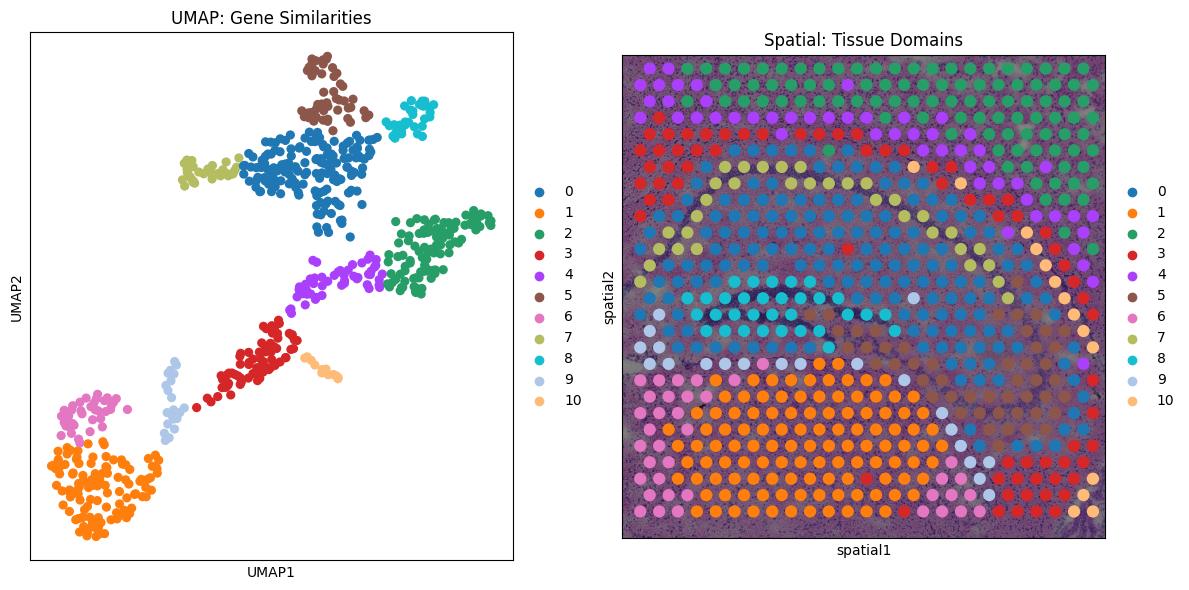

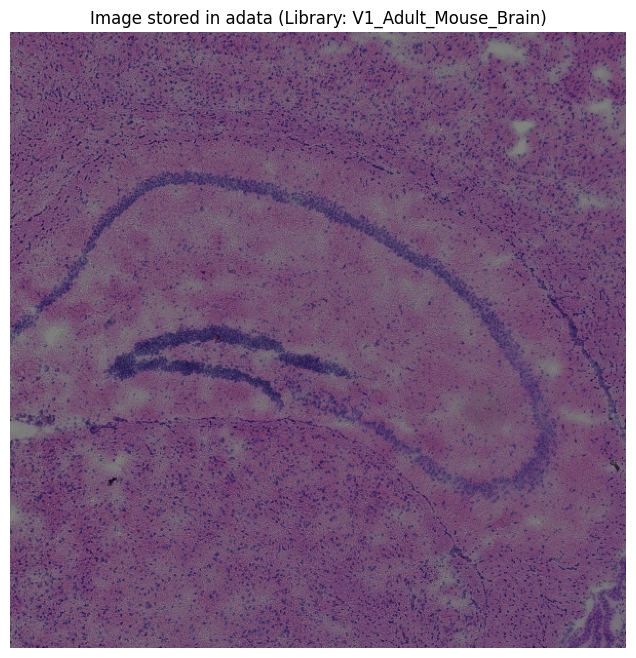

In [5]:
try:
    del adata.uns['leiden_colors']
    print("Old colors deleted. Generating new palette...")
except KeyError:
    print("No old colors found. Proceeding...")

# Create a figure with two panels side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: UMAP (The Math View)
# This shows how similar spots are in "gene expression space".
# If the dots separate into distinct islands, your clustering worked.
sc.pl.umap(adata, color="leiden", ax=ax[0], show=False, title="UMAP: Gene Similarities")

# Plot 2: Spatial (The Biology View)
# We paint the spots on the actual tissue image using the same colors.
# CRITICAL CHECK: Do the colors form random noise, or coherent shapes?
sq.pl.spatial_scatter(
    adata, 
    color="leiden", 
    img=img, 
    img_alpha=1.0, 
    ax=ax[1], 
    title="Spatial: Tissue Domains"
)

plt.tight_layout()

# 1. Get the library ID (the internal name of the image)
# keys() returns a list, we just want the first one
lib_id = list(adata.uns['spatial'].keys())[0]

# 2. Grab the image from the dictionary
stored_img = adata.uns['spatial'][lib_id]['images']['hires']

# 3. Plot it
plt.figure(figsize=(8, 8))
plt.imshow(stored_img)
plt.title(f"Image stored in adata (Library: {lib_id})")
plt.axis('off')
plt.show()

The top marker for Cluster 8 is: C1ql2


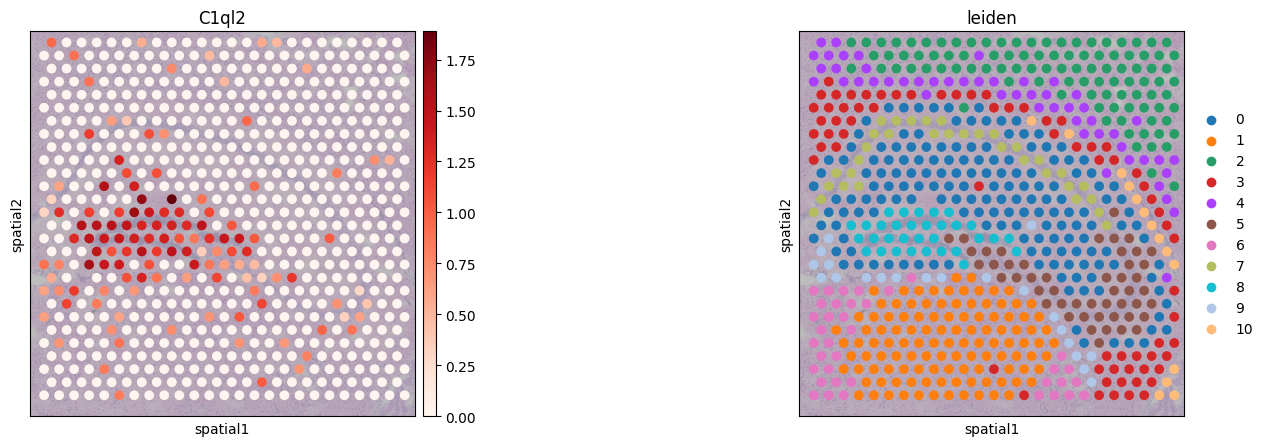

In [6]:
# 1. Rank Genes (One-vs-Rest t-test)
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')

# 2. Extract the name of the #1 gene for Cluster 8
# We access the structured array 'names' inside the 'rank_genes_groups' slot
top_gene_cluster_8 = adata.uns['rank_genes_groups']['names']['8'][0]
print(f"The top marker for Cluster 8 is: {top_gene_cluster_8}")

# 3. Validate Spatially
# Does the gene map match the cluster map?
sq.pl.spatial_scatter(
    adata, 
    color=[top_gene_cluster_8, "leiden"], 
    img=img, 
    img_alpha=0.5, 
    cmap="Reds", 
    figsize=(10, 5)
)

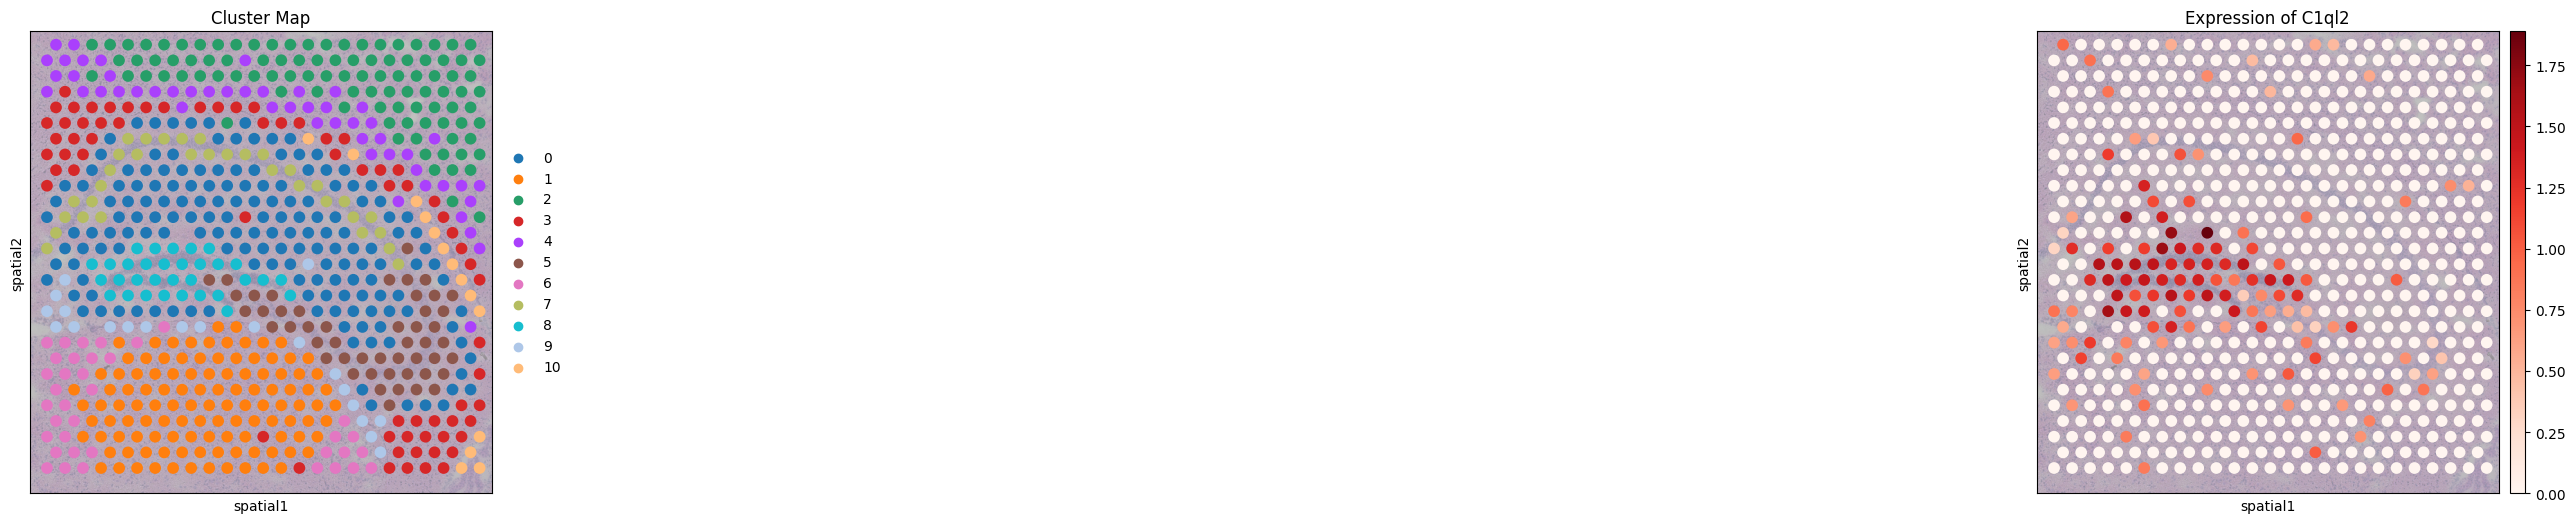